In [1]:
#import libraries
import re
import nltk
import sklearn
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
tweets_5G = '/$PATH/#5G_tweets.csv'

tweet_data = pd.read_csv(tweets_5G, sep = ",", engine='python')

tweet_data.shape

(207830, 19)

In [3]:
# remove all rows with non-English tweet text content, as per Twitter's machine-detection
# https://towardsdatascience.com/how-to-filter-rows-of-a-pandas-dataframe-by-column-value-51996ea621f8

lang_truth_table = tweet_data.lang.str.contains('en')
tweets = tweet_data[lang_truth_table]
tweets.shape

(134231, 19)

In [4]:
print('Number of rows removed: ' + str(tweet_data.shape[0] - tweets.shape[0]) + ' / ' + str(tweet_data.shape[0]) + '')
print('Percentage of English-language tweets is ' + str(round(tweets.shape[0] / tweet_data.shape[0] * 100, 1)) + '%')

Number of rows removed: 73599 / 207830
Percentage of English-language tweets is 64.6%


In [5]:
# drop duplicate tweets with different id_str (some retweets cause this)
# https://www.interviewqs.com/ddi_code_snippets/drop_duplicate_rows_pandas
tweets = tweets.drop_duplicates(subset='text', keep="first")

print('Number of rows removed: ' + str(tweet_data.shape[0] - tweets.shape[0]) + ' / ' + str(tweet_data.shape[0]) + '')
print('Percentage of tweets left is ' + str(round(tweets.shape[0] / tweet_data.shape[0] * 100, 1)) + '%')

Number of rows removed: 150994 / 207830
Percentage of tweets left is 27.3%


In [6]:
tweets.shape

(56836, 19)

In [7]:
# drop unnecessary columns 
# https://cmdlinetips.com/2018/04/how-to-drop-one-or-more-columns-in-pandas-dataframe/
tweets = tweets.drop(['from_user', 'lang', 'time', 'user_followers_count', 'user_friends_count', 'favorite_count        ', 'retweet_count        ', 'created_at', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'from_user_id_str', 'in_reply_to_status_id_str',  'source',  'profile_image_url',  'user_location',  'status_url',  'entities_str'], axis=1)

In [8]:
# extract hashtags from tweet text content and create new column 'hashtags' in lower case
# https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e

def lower_case(x):
    result = []
    for word in x:
        result.append(word.lower())
    return result

tweets['hashtags'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))
tweets['hashtags'] = tweets['hashtags'].apply(lambda x: lower_case(x))

In [9]:
# clean tweets from url's, mentions, hashtags, reserved words (RT, FAV), emojis and smileys, and numbers
# also, makes the cleaned text lowercase

import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY)
list = []

for i,v in enumerate(tweets['text']):
    list.append( p.clean(v).lower() )

tweets['text_cleaned'] = list

In [10]:
# remove extra white spaces and punctuation

list = []

for i,v in enumerate(tweets['text_cleaned']):
    tweet = re.sub('&amp;', '', v)
    tweet = re.sub('[^\w\s]', '', tweet)
    tweet = re.sub('\s\s+', ' ', tweet)
    
#    if tweet[0] == ' ':
#        tweet = tweet[1:]
    
    list.append(tweet)

tweets['text_cleaned'] = list

In [11]:
# remove stop words with gensim
# https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

from gensim.parsing.preprocessing import remove_stopwords

list = []

for i,v in enumerate(tweets['text_cleaned']):
    text = remove_stopwords(v)
    list.append(text)

tweets['text_cleaned'] = list

In [12]:
# remove rows which feature only one word in cleaned text

lang_truth_table = tweets.text_cleaned.str.contains(' ')
tweets = tweets[lang_truth_table]

tweets.shape

(55666, 4)

In [13]:
# create new column with words of a tweet as a list

list = []

for i,v in enumerate(tweets['text_cleaned']):
    words = v.split(' ')
    list.append(words)

tweets['words_cleaned'] = list

tweets['words_cleaned'].head(5)

1                   [reducing, reusing, recycling, ty]
2    [closing, year, belter, episode, trust, networ...
3    [2020, held, november, 26, 28, convention, gat...
4    [5g, pioneer, launching, campus, lead, plant, ...
5    [knows, borders, communication, mutual, learni...
Name: words_cleaned, dtype: object

In [14]:
# lemmatization

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_lemma(x):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(words) for words in x]

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : get_lemma(x))
tweets['words_cleaned'].head(5)

1                   [reducing, reusing, recycling, ty]
2    [closing, year, belter, episode, trust, networ...
3    [2020, held, november, 26, 28, convention, gat...
4    [5g, pioneer, launching, campus, lead, plant, ...
5    [know, border, communication, mutual, learning...
Name: words_cleaned, dtype: object

In [15]:
# removal of duplicate words
# https://stackoverflow.com/questions/8200342/removing-duplicate-strings-from-a-list-in-python
def remove_duplicates(x):
    seen = set()
    result = []
    for word in x:
        if word not in seen:
            seen.add(word)
            result.append(word)
    return result

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : remove_duplicates(x))
tweets['words_cleaned'].head(7)

1                   [reducing, reusing, recycling, ty]
2    [closing, year, belter, episode, trust, networ...
3    [2020, held, november, 26, 28, convention, gat...
4    [5g, pioneer, launching, campus, lead, plant, ...
5    [know, border, communication, mutual, learning...
6                             [10, key, tip, aspiring]
7                   [reducing, reusing, recycling, ty]
Name: words_cleaned, dtype: object

In [16]:
# removal of words and strings with a length of two (e.g. 'w/' i.e. 'w', which is a stopword), excluding 4g and 3g
# ALSO we allow removing '5g', since its a collection word (we are using it to fetch the data)

def remove_one_character_strings(x):
    result = []
    for word in x:
        if len(word) > 2 or word == '4g' or word == '3g':
            result.append(word)
    return result

tweets['words_cleaned'] = tweets['words_cleaned'].apply(lambda x : remove_one_character_strings(x))
tweets['words_cleaned'].head(7)

1                       [reducing, reusing, recycling]
2    [closing, year, belter, episode, trust, networ...
3    [2020, held, november, convention, gather, sci...
4    [pioneer, launching, campus, lead, plant, feue...
5    [know, border, communication, mutual, learning...
6                                 [key, tip, aspiring]
7                       [reducing, reusing, recycling]
Name: words_cleaned, dtype: object

In [67]:
# categorization of tweets based on conspiracy-content
# with our custom library of conspiracy-related words and hashtags

with open('/$PATH/conspiracy_stop_words.txt', 'r') as f:
    conspiracy_stop_words = [line.rstrip('\n') for line in f]
    f.close()
    
with open('/$PATH/conspiracy_stop_hashtags.txt', 'r') as f:
    conspiracy_stop_hashtags = [line.rstrip('\n') for line in f]
    f.close()

def has_conspiracy_content(y, z):
    result = False
    for word in y:
        if word in conspiracy_stop_words:
            result = True
    for hashtag in z:
        if hashtag in conspiracy_stop_hashtags:
            result = True
    return result

tweets['is_conspiracy_related'] = tweets.apply(lambda x : True if has_conspiracy_content(x['words_cleaned'], x['hashtags']) else False, axis=1)

In [68]:
# categorization of tweets based on conspiracy-content
# with custom library of conspiracy-related words and hashtags
pd.options.display.max_colwidth = 400

conspiracy_truth_table = tweets['is_conspiracy_related']
conspiracy_tweets = tweets[conspiracy_truth_table]

In [19]:
######################################### RATIO BETWEEN CONSPIRATORY AND NON-CONSPIRATORY ###############################################

In [20]:
print('Number of conspiratory tweets: ' + str(conspiracy_tweets.shape[0]) + ' out of ' + str(tweets.shape[0]) + '')
print('Percentage of conspiratory tweets ' + str(round(conspiracy_tweets.shape[0] / tweets.shape[0] * 100, 1)) + '%')

Number of conspiratory tweets: 1471 out of 55666
Percentage of conspiratory tweets 2.6%


In [21]:
#########################################################################################################################################

In [22]:
#### #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### ####

In [23]:
#### #### #### #### #### #### #### #### #### #### ANALYZING CONSPIRATORY TWEETS #### #### #### #### #### #### #### #### #### #### #### 

In [24]:
#### #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### ####

In [25]:
#### CONSPIRATORY WORDS ####

In [26]:
# flatten list of all words in all conspiratory tweets and create a list of collections with the words and their counts

import itertools
import collections

# clear list variable, since it gets initialized for some reason
# and this then breaks the following 
del list

# List of all words across tweets
all_words = list(itertools.chain(*conspiracy_tweets['words_cleaned']))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15)

[('radiation', 359),
 ('lie', 125),
 ('people', 119),
 ('emf', 107),
 ('health', 105),
 ('symptom', 86),
 ('exposure', 80),
 ('danger', 78),
 ('vaccine', 75),
 ('cause', 72),
 ('new', 69),
 ('tower', 67),
 ('time', 65),
 ('cell', 65),
 ('real', 65)]

In [27]:
clean_conspiracy_tweets = pd.DataFrame(counts.most_common(50),
                             columns=['words', 'count'])

clean_conspiracy_tweets.head(10)

,words,count
0,radiation,359
1,lie,125
2,people,119
3,emf,107
4,health,105
5,symptom,86
6,exposure,80
7,danger,78
8,vaccine,75
9,cause,72


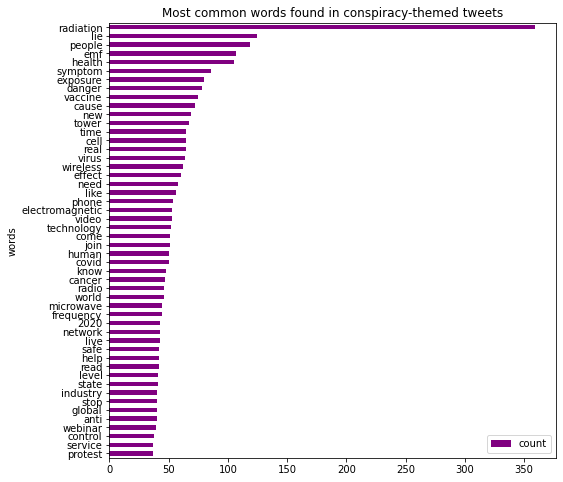

In [28]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_conspiracy_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most common words found in conspiracy-themed tweets")

plt.show()

In [29]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

conspiracy_tweets['text_cleaned'] = conspiracy_tweets['words_cleaned'].apply(lambda x : combineIntoString(x))
conspiracy_tweets['text_cleaned'].head(7)

512                                                                                                                                     released, expert, panel, discussion
565                                                                people, exposed, blood, oxygenate, properly, went, hospital, bathed, radiation, wifi, bed, clotted, died
671                                                                     testimony, suffered, impact, health, working, airport, article, give, advice, protecting, radiation
937                                                                                             life, entwined, nature, balance, molecule, harmony, destroy, visit, website
958                                                                                 awareness, increased, independent, research, critical, related, mobile, smart, industry
1803                     wouldnt, helped, admit, burning, bio, fuel, ongoing, time, wuhan, italy, london, newyork, switched, prior, advent, 

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

text_tfidf = tfidf_vectorizer.fit_transform(conspiracy_tweets['text_cleaned'])

In [31]:
occ = np.asarray(text_tfidf.sum(axis=0)).ravel().tolist()
tfidf_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ})

tfidf_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
1023,radiation,53.054486
934,people,26.968484
751,lie,24.895213
316,danger,24.519969
427,emf,23.147457
604,health,22.822489
1345,vaccine,20.726469
1038,real,19.230237
1237,symptom,18.765188
483,exposure,18.567078


In [32]:
#### CONSPIRATORY HASHTAGS ####

In [33]:
# flatten list of all words in all tweets and create a list of collections with the words and their counts

import itertools
import collections

# List of all words across tweets
all_conspiracy_hashtags = list(itertools.chain(*conspiracy_tweets['hashtags']))

# Create counter
counts_conspiracy_hashtags = collections.Counter(all_conspiracy_hashtags)

counts_conspiracy_hashtags.most_common(15)

[('5g', 1492),
 ('covid19', 253),
 ('emf', 222),
 ('radiation', 164),
 ('nwo', 137),
 ('stop5g', 129),
 ('vaccines', 120),
 ('cancer', 106),
 ('health', 92),
 ('vaccine', 71),
 ('ai', 68),
 ('lockdown', 60),
 ('wireless', 59),
 ('billgates', 55),
 ('news', 54)]

In [34]:
clean_conspiracy_hashtags = pd.DataFrame(counts_conspiracy_hashtags.most_common(50),
                             columns=['words', 'count'])

clean_conspiracy_hashtags = clean_conspiracy_hashtags[1:]
clean_conspiracy_hashtags.head(10)

,words,count
1,covid19,253
2,emf,222
3,radiation,164
4,nwo,137
5,stop5g,129
6,vaccines,120
7,cancer,106
8,health,92
9,vaccine,71
10,ai,68


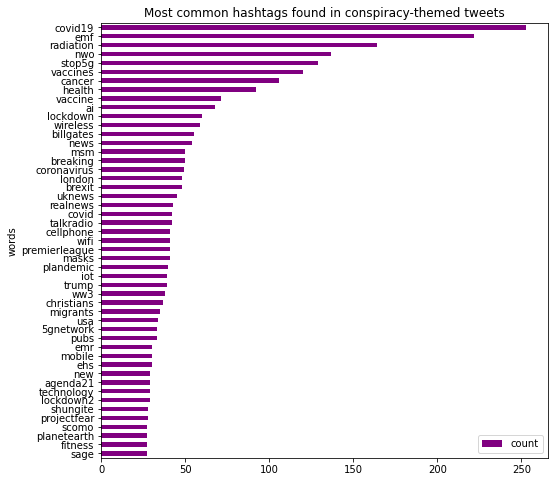

In [35]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_conspiracy_hashtags.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most common hashtags found in conspiracy-themed tweets")

plt.show()

In [36]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

conspiracy_tweets['hashtags_cleaned'] = conspiracy_tweets['hashtags'].apply(lambda x : combineIntoString(x))
conspiracy_tweets['hashtags_cleaned'].head(7)

512     new, 2019, conference, authors, brianclement, katiesinger, theodorascarato, cellphone, radiation, 5g, wireless
565                                                                      wuhan, northernitaly, london, newyork, 5g, 5g
671                                                                                                            5g, emf
937                                    5gjusticeuk, 5g, 5gdangers, health, publicsafety, emfprotection, wedonotconsent
958                                                                                                            5g, emf
1803                                                                                                                5g
2097                                                                                                                5g
Name: hashtags_cleaned, dtype: object

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

text_tfidf = tfidf_vectorizer.fit_transform(conspiracy_tweets['hashtags_cleaned'])

In [38]:
occ = np.asarray(text_tfidf.sum(axis=0)).ravel().tolist()
tfidf_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ})

tfidf_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
125,covid19,96.092162
176,emf,93.830832
393,radiation,62.403782
349,nwo,46.751435
454,stop5g,42.572778
85,cancer,38.416540
500,vaccines,38.294855
236,health,31.398258
499,vaccine,30.086203
65,billgates,24.464007


In [39]:
#### SENTIMENT: CONSPIRATORY #####

In [40]:
# Analyze the sentiment with Vader
# https://github.com/pjwebdev/Basic-Data-Science-Projects/blob/master/8-Twitter-Sentiment-Analysis/Tweeter%20Sentiment%20Analysis.ipynb

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

scores = []

for sentence in conspiracy_tweets['text']:
    score = analyser.polarity_scores(sentence)
    c = score['compound']
    if c < 0:
        value = 'Negative'
    elif c == 0:
        value = 'Neutral'
    else:
        value = 'Positive'
    scores.append(value)

conspiracy_tweets['sentiment'] = scores

In [41]:
conspiracy_tweets.head(6)

,id_str,text,hashtags,text_cleaned,words_cleaned,is_conspiracy_related,hashtags_cleaned,sentiment
512,1331920650806710272,"#New #2019 #Conference - Just Released, #authors, #BrianClement, #KatieSinger, #TheodoraScarato; An expert panel discussion on About #CellPhone #Radiation and #5G #Wireless, https://t.co/IpprWpukKC","[new, 2019, conference, authors, brianclement, katiesinger, theodorascarato, cellphone, radiation, 5g, wireless]","released, expert, panel, discussion","[released, expert, panel, discussion]",True,"new, 2019, conference, authors, brianclement, katiesinger, theodorascarato, cellphone, radiation, 5g, wireless",Neutral
565,1331918312352206852,"RT @2013Boodicca: The people of #Wuhan &amp; #NorthernItaly, then #London &amp; #NewYork etc were exposed to #5G.\nTheir blood couldn't oxygenate properly.\nThey went to hospitals where they were bathed in more #5G radiation from wifi to every bed.\nTheir blood clotted &amp; they died.\nhttps://t.co/srkItnu6qR","[wuhan, northernitaly, london, newyork, 5g, 5g]","people, exposed, blood, oxygenate, properly, went, hospital, bathed, radiation, wifi, bed, clotted, died","[people, exposed, blood, oxygenate, properly, went, hospital, bathed, radiation, wifi, bed, clotted, died]",True,"wuhan, northernitaly, london, newyork, 5g, 5g",Negative
671,1331914317197946880,RT @2013Boodicca: @rosemaryhopkin You are not alone. Here is testimony from someone who suffered #5G impact on his health while working at one of our airports.\nThis article also gives some advice about protecting yourself from #EMF radiation.\nhttps://t.co/CnZeGqVXpS,"[5g, emf]","testimony, suffered, impact, health, working, airport, article, give, advice, protecting, radiation","[testimony, suffered, impact, health, working, airport, article, give, advice, protecting, radiation]",True,"5g, emf",Negative
937,1331905175577972737,RT @ActionAgainst5G: Life entwined. Nature in balance. Molecules in harmony. Why would anyone destroy it?\n\nhttps://t.co/336cQl2EyQ\n\nVisit our website: https://t.co/pKHofynGKp\n\n#5gjusticeuk\n#5g #5gdangers #health #publicsafety #emfprotection #wedonotconsent https://t.co/lpFpdxVeeN,"[5gjusticeuk, 5g, 5gdangers, health, publicsafety, emfprotection, wedonotconsent]","life, entwined, nature, balance, molecule, harmony, destroy, visit, website","[life, entwined, nature, balance, molecule, harmony, destroy, visit, website]",True,"5gjusticeuk, 5g, 5gdangers, health, publicsafety, emfprotection, wedonotconsent",Negative
958,1331904456116613122,#5G Awareness #EMF increased independent research is critical &amp; not by any one related to the Mobile or Smart industry. https://t.co/seiMpPeqC8,"[5g, emf]","awareness, increased, independent, research, critical, related, mobile, smart, industry","[awareness, increased, independent, research, critical, related, mobile, smart, industry]",True,"5g, emf",Positive
1803,1331875907892633601,"RT @2013Boodicca: @Manofthesoil2 That wouldn't have helped much either, but you have to admit that the burning of bio fuel had been ongoing for some time in Wuhan (but not in Italy or London or NewYork).\n#5G was switched on just prior to the advent of the symptoms we have been told to associate with a ""virus"".",[5g],"wouldnt, helped, admit, burning, bio, fuel, ongoing, time, wuhan, italy, london, newyork, switched, prior, advent, symptom, told, associate, virus","[wouldnt, helped, admit, burning, bio, fuel, ongoing, time, wuhan, italy, london, newyork, switched, prior, advent, symptom, told, associate, virus]",True,5g,Positive


<BarContainer object of 3 artists>

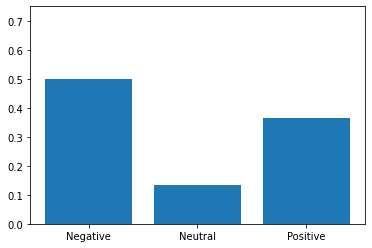

In [42]:
labels = conspiracy_tweets.groupby('sentiment').count().index.values

values = conspiracy_tweets.groupby('sentiment').size().values

axes = plt.gca()
axes.set_ylim([0.0, 0.75])

plt.bar(labels, values / conspiracy_tweets.shape[0] )

In [43]:
positive = conspiracy_tweets[conspiracy_tweets['sentiment'] == 'Positive']

print(str(round(positive.shape[0]/(conspiracy_tweets.shape[0])*100, 2)) + " % of positive tweets")

36.57 % of positive tweets


In [44]:
#### #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### ####

In [45]:
#### #### #### #### #### #### #### #### #### #### ANALYZING NON-CONSPIRATORY TWEETS #### #### #### #### #### #### #### #### #### #### #### 

In [46]:
#### #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### #### #### #### #### ######## #### #### ####

In [47]:
# Then let's analyze the non-conspiratory tweets
non_conspiracy_tweets = tweets[tweets['is_conspiracy_related'] == False]
non_conspiracy_tweets.shape

(54195, 6)

In [49]:
#### NON-CONSPIRATORY WORDS ####

In [50]:
# flatten list of all words in all conspiratory tweets and create a list of collections with the words and their counts

import itertools
import collections

# List of all words across tweets
all_words = list(itertools.chain(*non_conspiracy_tweets['words_cleaned']))

# Create counter
counts = collections.Counter(all_words)

counts.most_common(15)

[('network', 7085),
 ('new', 5410),
 ('technology', 3950),
 ('read', 3312),
 ('learn', 2653),
 ('future', 2373),
 ('business', 2309),
 ('service', 2308),
 ('join', 2303),
 ('industry', 2291),
 ('world', 2119),
 ('use', 1980),
 ('mobile', 1887),
 ('need', 1823),
 ('today', 1779)]

In [51]:
clean_non_conspiracy_tweets = pd.DataFrame(counts.most_common(50),
                             columns=['words', 'count'])

clean_non_conspiracy_tweets.head(10)

,words,count
0,network,7085
1,new,5410
2,technology,3950
3,read,3312
4,learn,2653
5,future,2373
6,business,2309
7,service,2308
8,join,2303
9,industry,2291


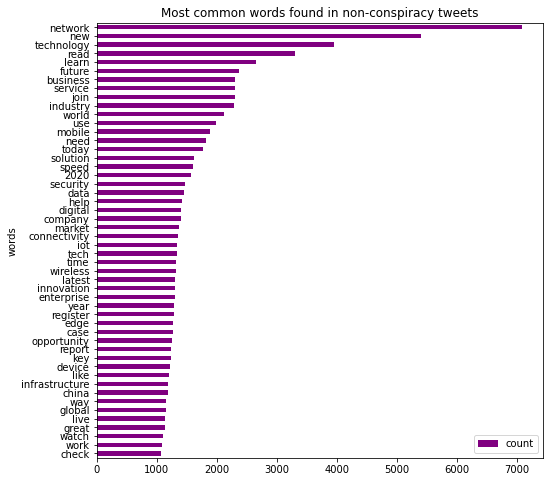

In [52]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_non_conspiracy_tweets.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most common words found in non-conspiracy tweets")

plt.show()

In [53]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

non_conspiracy_tweets['text_cleaned'] = non_conspiracy_tweets['words_cleaned'].apply(lambda x : combineIntoString(x))
non_conspiracy_tweets['text_cleaned'].head(7)

1                                                                                                                                                      reducing, reusing, recycling
2                                                                      closing, year, belter, episode, trust, network, remotely, ink, skin, thanks, week, sponsor, content, partner
3     2020, held, november, convention, gather, scientist, service, provider, communication, industry, conduct, discussion, cuttingedge, technology, trend, innovative, application
4    pioneer, launching, campus, lead, plant, feuerbach, germany, enables, extremely, reliable, ultrafast, wireless, transfer, critical, application, autonomous, transport, system
5                                                                 know, border, communication, mutual, learning, develop, technology, life, world, transformed, better, importantly
6                                                                                                   

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

text_tfidf = tfidf_vectorizer.fit_transform(non_conspiracy_tweets['text_cleaned'])

In [55]:
occ = np.asarray(text_tfidf.sum(axis=0)).ravel().tolist()
tfidf_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ})

tfidf_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
7388,network,1058.472974
7406,new,879.242328
10661,technology,715.803552
8797,read,690.055552
4771,future,549.853865
6350,learn,517.391042
2060,business,485.267777
5681,industry,469.688568
6075,join,457.571670
11826,world,455.032170


In [56]:
#### NON-CONSPIRATORY HASHTAGS ####

In [57]:
# flatten list of all words in all tweets and create a list of collections with the words and their counts

import itertools
import collections

# List of all words across tweets
all_non_conspiracy_hashtags = list(itertools.chain(*non_conspiracy_tweets['hashtags']))

# Create counter
counts_non_conspiracy_hashtags = collections.Counter(all_non_conspiracy_hashtags)

counts_non_conspiracy_hashtags.most_common(15)

[('5g', 55105),
 ('iot', 10748),
 ('ai', 9679),
 ('bigdata', 3808),
 ('cloud', 3757),
 ('tech', 3602),
 ('digitaltransformation', 3363),
 ('machinelearning', 3023),
 ('technology', 2848),
 ('datascience', 2616),
 ('edge', 2425),
 ('cybersecurity', 2366),
 ('iiot', 2348),
 ('artificialintelligence', 1869),
 ('innovation', 1690)]

In [58]:
clean_non_conspiracy_hashtags = pd.DataFrame(counts_non_conspiracy_hashtags.most_common(50),
                             columns=['words', 'count'])

clean_non_conspiracy_hashtags = clean_non_conspiracy_hashtags[1:]
clean_non_conspiracy_hashtags.head(10)

,words,count
1,iot,10748
2,ai,9679
3,bigdata,3808
4,cloud,3757
5,tech,3602
6,digitaltransformation,3363
7,machinelearning,3023
8,technology,2848
9,datascience,2616
10,edge,2425


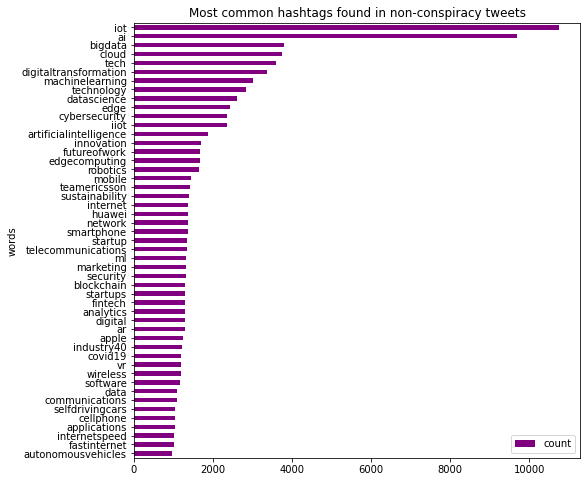

In [59]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_non_conspiracy_hashtags.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most common hashtags found in non-conspiracy tweets")

plt.show()

In [60]:
# turn lists of strings into strings, divided with commas

def combineIntoString(x):
    return ', '.join(x)

non_conspiracy_tweets['hashtags_cleaned'] = non_conspiracy_tweets['hashtags'].apply(lambda x : combineIntoString(x))
non_conspiracy_tweets['hashtags_cleaned'].head(7)

1                       climatechange, ai, iot, renewables, data, fintech, insurtech, proptech, digitalbanks, openbanking, blockchain, marketing, retailtech, agrifarm, agritech, cx, govtech, 5g, edtech, sustainability, environment, sdgs
2                                                                                                                                                                                                       mwlthemedweek, mobilemix, 5g, tattoo
3                                                                                                                                                                                                           world5gconvention, guangzhou, 5g
4                                                                                                                                                                                               5g, network, industry40, data, manufacturing
5                                                   

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def preProcessor(s):
    # we did all the preprocessing already, so return as is
    return s
    
pd.options.display.max_colwidth = 1000
pd.set_option('display.max_columns', None)

tfidf_vectorizer = TfidfVectorizer(preprocessor = preProcessor,
                                   max_df=0.75, min_df=3, use_idf=True)

text_tfidf = tfidf_vectorizer.fit_transform(non_conspiracy_tweets['hashtags_cleaned'])

In [62]:
occ = np.asarray(text_tfidf.sum(axis=0)).ravel().tolist()
tfidf_scores = pd.DataFrame({'terms': tfidf_vectorizer.get_feature_names(), 'tfidf': occ})

tfidf_scores.sort_values('tfidf',ascending=False).head(20)

,terms,tfidf
3080,iot,2504.693681
373,ai,1980.090873
5439,teamericsson,1210.387683
1219,cloud,1050.641464
1755,digitaltransformation,1034.641936
5449,tech,896.543689
5486,technology,819.784031
1913,edge,782.016055
795,bigdata,734.076955
1918,edgecomputing,715.369739


In [63]:
#### SENTIMENT: NON-CONSPIRATORY #####

In [64]:
# Analyze the sentiment with Vader
# https://github.com/pjwebdev/Basic-Data-Science-Projects/blob/master/8-Twitter-Sentiment-Analysis/Tweeter%20Sentiment%20Analysis.ipynb

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

scores = []

for sentence in non_conspiracy_tweets['text']:
    score = analyser.polarity_scores(sentence)
    c = score['compound']
    if c < 0:
        value = 'Negative'
    elif c == 0:
        value = 'Neutral'
    else:
        value = 'Positive'
    scores.append(value)

non_conspiracy_tweets['sentiment'] = scores

<BarContainer object of 3 artists>

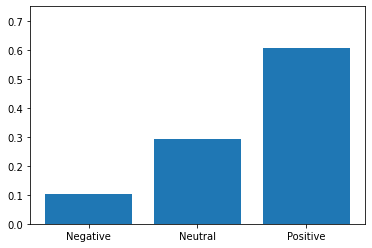

In [65]:
labels = non_conspiracy_tweets.groupby('sentiment').count().index.values

values = non_conspiracy_tweets.groupby('sentiment').size().values

axes = plt.gca()
axes.set_ylim([0, 0.75])

plt.bar(labels, values / non_conspiracy_tweets.shape[0] )

In [66]:
positive = non_conspiracy_tweets[non_conspiracy_tweets['sentiment'] == 'Positive']

print(str(round(positive.shape[0]/(non_conspiracy_tweets.shape[0])*100, 2)) + " % of positive tweets")

60.59 % of positive tweets
